In [377]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.neighbors as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

labels = []
def load_data(data_dir):
    # Define the image size for preprocessing
    img_size = (200, 200)
    genders = ['men', 'Women']
    # Define the label names and corresponding integer values
    label_names = ['0', '1', '2', '3', '4', '5']
    label_dict = {label_names[i]: i for i in range(len(label_names))}

    # Initialize empty lists for the images and labels
    images = []

    # Loop over the gender folders
    for gender in genders:
        gender_dir = os.path.join(data_dir, gender)
        # Loop over the label names
        for label_name in label_names:
            # Get the path to the label folder
            label_dir = os.path.join(gender_dir, label_name)
            # Loop over the images in the label folder
            for file_name in os.listdir(label_dir):
                # Get the path to the image file
                file_path = os.path.join(label_dir, file_name)
                # Load the image file and preprocess it
                img = cv2.imread(file_path)
                if img is None:
                    continue
                # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, img_size)
                img_normalized = img_resized / 255.0
                # Append the preprocessed image and corresponding label to the lists
                images.append(img_normalized)
                labels.append(label_dict[label_name])

    # Convert the image and label lists to numpy arrays
    X_train = np.array(images)
    y_train = np.array(labels)
    
    return X_train, y_train

In [378]:
X_train, y_train = load_data('Dataset_0-5/')
print(len(y_train))
# sorted_indices = np.argsort(y_train)
# X_train = X_train[sorted_indices]
# y_train=np.asarray(sorted(y_train))

1821


In [379]:
def remove_shadows(image):
    # convert to LAB color space
    # print('image', image.dtype)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        

    # split the LAB channels
    l, a, b = cv2.split(lab)
    
    # apply the Retinex algorithm to the L channel
    # set the gain to 128 for best results
    l = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3)).apply(l)
    # merge the LAB channels back together
    lab = cv2.merge((l,a,b))

    # convert back to BGR color space
    result = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return result

In [380]:
def preprocess_images_thresh(images):
    X_processed = []
    light_skin = np.array([8, 50, 50],np.uint8)
    dark_skin = np.array([50, 255, 255],np.uint8)
    
    for i in range(len(images)):
        img = images[i]
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        blur_img = cv2.GaussianBlur(img,(5,5),0)
        denoised_img = cv2.fastNlMeansDenoisingColored(blur_img,None,3,3,7,21)
        hsv_img = cv2.cvtColor(denoised_img,cv2.COLOR_BGR2HSV)
        frame_threshed = cv2.inRange(hsv_img, light_skin, dark_skin)
        X_processed.append(frame_threshed)
    
    X_processed = np.array(X_processed)
    return X_processed


In [381]:
def preprocess_images_blurred(images):
    X_processed = []
    
    for i in range(len(images)):
        img = images[i]
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred_input = cv2.medianBlur(gray,5)
        X_processed.append(blurred_input)
    
    X_processed = np.array(X_processed)
    return X_processed


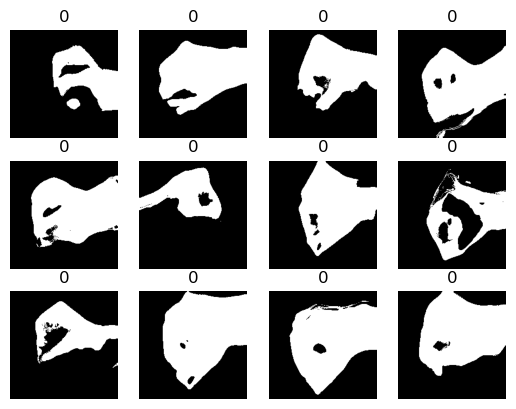

In [382]:
X_train_processed = preprocess_images_thresh(X_train)
for i in range(0, 12):
    plt.subplot(3,4,i+1)
    plt.imshow(X_train_processed[i], cmap='gray')
    plt.title(y_train[i+33])
    plt.axis('off')


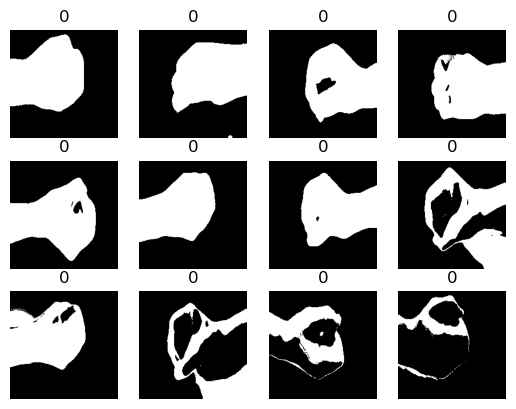

In [383]:
for i in range(0, 12):
    plt.subplot(3,4,i+1)
    plt.imshow(X_train_processed[i+33], cmap='gray')
    plt.title(y_train[i+40])
    plt.axis('off')

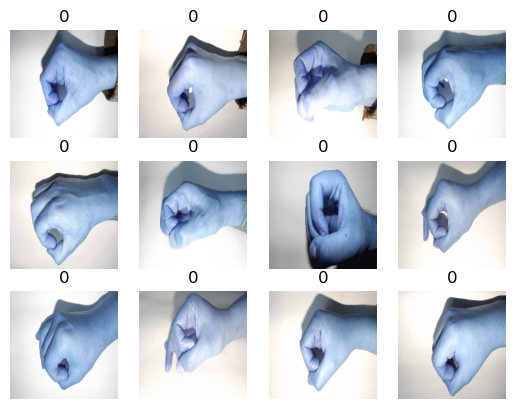

In [384]:
for i in range(0, 12):
    plt.subplot(3,4,i+1)
    plt.imshow(X_train[i+6], cmap='gray')
    plt.title(y_train[i+6])
    plt.axis('off')

In [420]:
# Preprocess the images to extract Hu Moments as a feature
def extract_hu_moments(grayscale_img):
    moments = cv2.moments(grayscale_img)
    hu_moments = cv2.HuMoments(moments).flatten()
    # Log-scale the Hu moments to make them more invariant to changes in scale
    log_hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
    # Return only the first two Hu moments
    return log_hu_moments[:2].flatten()
    
def extract_features(binary_img):
    height, width = binary_img.shape
    left_half_img = binary_img[:, :width//2]  # Extract the left half of the image
    right_half_img = binary_img[:, width//2:]  # Extract the right half of the image
    left_white_pixel_count = np.count_nonzero(left_half_img)
    right_white_pixel_count = np.count_nonzero(right_half_img)
    if left_white_pixel_count > right_white_pixel_count:
        return right_white_pixel_count
    else:
        return left_white_pixel_count

X_train_hu = []
for i in range(len(X_train)):
    img_gray = cv2.cvtColor((X_train[i] * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    hu_moments = extract_hu_moments(img_gray)
    X_train_hu.append(hu_moments)

training_features=np.zeros((X_train_processed.shape[0],1))

for i in range(training_features.shape[0]):
    training_features[i]=extract_features(X_train_processed[i])


X_train_hu = np.array(X_train_hu)

single_feature=training_features


# Combine the original feature (pixel intensity) with the Hu Moments feature
training_features = np.concatenate((training_features.reshape(-1, 1), X_train_hu), axis=1)

# Print the shape of the combined feature matrix
print('X_train_combined shape:', training_features.shape)


X_train_combined shape: (1821, 3)


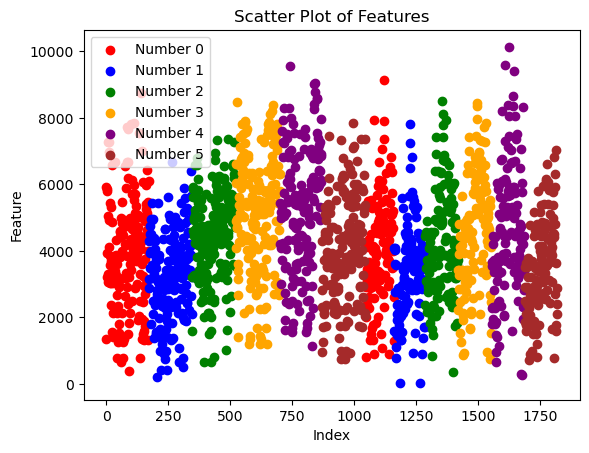

In [421]:
# Create an array of indices for each category
indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]
indices_2 = np.where(y_train == 2)[0]
indices_3 = np.where(y_train == 3)[0]
indices_4 = np.where(y_train == 4)[0]
indices_5 = np.where(y_train == 5)[0]

# Plot features with different colors for each category
plt.scatter(indices_0, single_feature[indices_0], color='red', label='Number 0')
plt.scatter(indices_1, single_feature[indices_1], color='blue', label='Number 1')
plt.scatter(indices_2, single_feature[indices_2], color='green', label='Number 2')
plt.scatter(indices_3, single_feature[indices_3], color='orange', label='Number 3')
plt.scatter(indices_4, single_feature[indices_4], color='purple', label='Number 4')
plt.scatter(indices_5, single_feature[indices_5], color='brown', label='Number 5')

plt.legend()  # Show legend
plt.xlabel('Index')
plt.ylabel('Feature')
plt.title('Scatter Plot of Features')

plt.show()



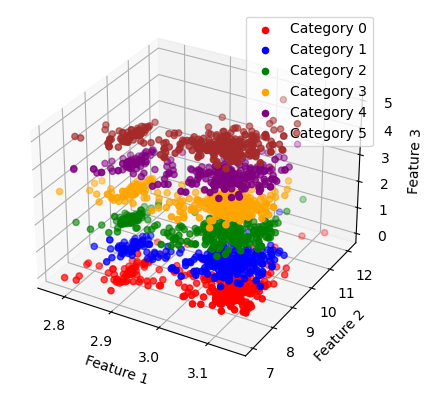

In [448]:
# Create an array of indices for each category
indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]
indices_2 = np.where(y_train == 2)[0]
indices_3 = np.where(y_train == 3)[0]
indices_4 = np.where(y_train == 4)[0]
indices_5 = np.where(y_train == 5)[0]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the features
ax.scatter(X_train_hu[indices_0, 0], X_train_hu[indices_0, 1], y_train[indices_0], color='red', label='Category 0')
ax.scatter(X_train_hu[indices_1, 0], X_train_hu[indices_1, 1], y_train[indices_1], color='blue', label='Category 1')
ax.scatter(X_train_hu[indices_2, 0], X_train_hu[indices_2, 1], y_train[indices_2], color='green', label='Category 2')
ax.scatter(X_train_hu[indices_3, 0], X_train_hu[indices_3, 1], y_train[indices_3], color='orange', label='Category 3')
ax.scatter(X_train_hu[indices_4, 0], X_train_hu[indices_4, 1], y_train[indices_4], color='purple', label='Category 4')
ax.scatter(X_train_hu[indices_5, 0], X_train_hu[indices_5, 1], y_train[indices_5], color='brown', label='Category 5')

# Set labels for the axes
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

# Show legend
ax.legend()

# Show the plot
plt.show()

IndexError: index 3 is out of bounds for axis 1 with size 3

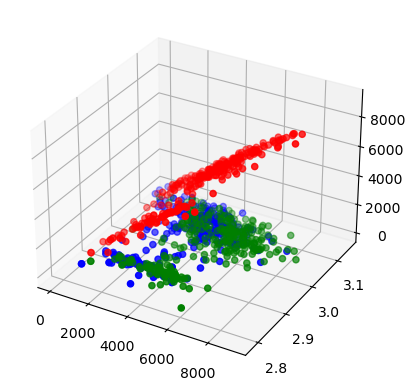

In [447]:
# Create an array of indices for each category
indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]
indices_2 = np.where(y_train == 2)[0]
indices_3 = np.where(y_train == 3)[0]
indices_4 = np.where(y_train == 4)[0]
indices_5 = np.where(y_train == 5)[0]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the features
ax.scatter(training_features[indices_0, 0], training_features[indices_0, 1], training_features[indices_0,0], color='red', label='Category 0')
ax.scatter(training_features[indices_1, 0], training_features[indices_1, 1], training_features[indices_1,1], color='blue', label='Category 1')
ax.scatter(training_features[indices_2, 0], training_features[indices_2, 1], training_features[indices_2,2], color='green', label='Category 2')
ax.scatter(training_features[indices_3, 0], training_features[indices_3, 1], training_features[indices_3,3], color='orange', label='Category 3')
ax.scatter(training_features[indices_4, 0], training_features[indices_4, 1], training_features[indices_4,4], color='purple', label='Category 4')
ax.scatter(training_features[indices_5, 0], training_features[indices_5, 1], training_features[indices_5,5], color='brown', label='Category 5')

# Set labels for the axes
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

# Show legend
ax.legend()

# Show the plot
plt.show()


In [445]:
x_fit, x_test, y_fit, y_test = train_test_split(X_train_hu, y_train, test_size=0.2, shuffle=True, stratify=labels)


# clf = svm.SVC()


# clf.fit(x_fit,y_fit)
# y_predict = clf.predict(x_test)

# score = accuracy_score(y_predict, y_test)

# print('Accuracy: {} % '. format(score * 100))


from sklearn.neighbors import KNeighborsClassifier

# Create an instance of the kNN classifier
clf = KNeighborsClassifier()

clf.fit(x_fit, y_fit)
y_predict = clf.predict(x_test)

score = accuracy_score(y_predict, y_test)

print('Accuracy: {} %'.format(score * 100))



Accuracy: 18.904109589041095 %


c:\Users\Omar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [417]:
x_fit, x_test, y_fit, y_test = train_test_split(training_features, y_train, test_size=0.2, shuffle=True, stratify=labels)


clf = svm.SVC()


clf.fit(x_fit,y_fit)
y_predict = clf.predict(x_test)

score = accuracy_score(y_predict, y_test)

print('Accuracy: {} % '. format(score * 100))


# from sklearn.neighbors import KNeighborsClassifier

# # Create an instance of the kNN classifier
# clf = KNeighborsClassifier()

# clf.fit(x_fit, y_fit)
# y_predict = clf.predict(x_test)

# score = accuracy_score(y_predict, y_test)

# print('Accuracy: {} %'.format(score * 100))



Accuracy: 26.575342465753426 % 
